In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
seed = 42

train_df = pd.read_csv("../dataset/APPA-REAL/appa-real-release/gt_avg_train.csv")
val_df = pd.read_csv("../dataset/APPA-REAL/appa-real-release/gt_avg_valid.csv")

train_df['age100'] = np.floor(train_df['apparent_age_avg'])
train_df['age100'] = train_df['age100'].clip(0, 99)

val_df['age100'] = np.floor(val_df['apparent_age_avg'])
val_df['age100'] = val_df['age100'].clip(0, 99)

# create age20 column
train_df['age20'] = np.floor(train_df['apparent_age_avg'] / 5)
train_df['age20'] = train_df['age20'].clip(0, 19)

val_df['age20'] = np.floor(val_df['apparent_age_avg'] / 5)
val_df['age20'] = val_df['age20'].clip(0, 19)

# create age10 column
train_df['age10'] = np.floor(train_df['apparent_age_avg'] / 10)
train_df['age10'] = train_df['age10'].clip(0, 9)

val_df['age10'] = np.floor(val_df['apparent_age_avg'] / 10)
val_df['age10'] = val_df['age10'].clip(0, 9)

# create age5 column
train_df['age5'] = np.floor(train_df['apparent_age_avg'] / 20)
train_df['age5'] = train_df['age5'].clip(0, 4)

val_df['age5'] = np.floor(val_df['apparent_age_avg'] / 20)
val_df['age5'] = val_df['age5'].clip(0, 4)

print(train_df.head())

    file_name  num_ratings  apparent_age_avg  apparent_age_std  real_age  \
0  000000.jpg           36          5.000000          1.146423         4   
1  000001.jpg           63         20.079365          4.096819        18   
2  000002.jpg           38         76.815789          6.133009        80   
3  000003.jpg           38         55.657895          7.864653        50   
4  000004.jpg           15         17.666667          3.457222        17   

   age100  age20  age10  age5  
0     5.0    1.0    0.0   0.0  
1    20.0    4.0    2.0   1.0  
2    76.0   15.0    7.0   3.0  
3    55.0   11.0    5.0   2.0  
4    17.0    3.0    1.0   0.0  


In [3]:
from keras.preprocessing.image import ImageDataGenerator
seed = 42
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="D:/imdb/Align.5/Train/",
    x_col="file_name",
    y_col=["age100", "age20", "age10",  "age5","apparent_age_avg"],
    batch_size=64,
    target_size=(224, 224),
    class_mode="multi_output",
    shuffle=True,
    seed=seed
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory="D:/imdb/Align.5/Valid/",
    x_col="file_name",
    y_col=["age100", "age20", "age10",  "age5","apparent_age_avg"],
    batch_size=64,
    target_size=(224, 224),
    class_mode="multi_output",
    shuffle=True,
    seed=seed
)

Found 4113 validated image filenames.
Found 1500 validated image filenames.


In [9]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization, concatenate
from keras.models import Sequential, Model, load_model
import coral_ordinal as coral

loss_array = {}
metrics_array = {}
#base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model = load_model("D:/models/FINAL/Mobile/testing/strat-cross-val2.h5")

#output100 = coral.CoralOrdinal(101, name="output100")(base_model.layers[-1].output)
loss_array['coral_ordinal_8'] = coral.OrdinalCrossEntropy(num_classes=101)
metrics_array['coral_ordinal_8'] = coral.MeanAbsoluteErrorLabels()

output20 = coral.CoralOrdinal(20, name="output20")(base_model.layers[-2].output)
loss_array['output20'] = coral.OrdinalCrossEntropy(num_classes=20)
metrics_array['output20'] = coral.MeanAbsoluteErrorLabels()

output10 = coral.CoralOrdinal(10, name="output10")(base_model.layers[-2].output)
loss_array['output10'] = coral.OrdinalCrossEntropy(num_classes=10)
metrics_array['output10'] = coral.MeanAbsoluteErrorLabels()

output5 = coral.CoralOrdinal(5, name="output5")(base_model.layers[-2].output)
loss_array['output5'] = coral.OrdinalCrossEntropy(num_classes=5)
metrics_array['output5'] = coral.MeanAbsoluteErrorLabels()

output_reg = Dense(1, activation='linear', name='output_reg')(base_model.layers[-2].output)
loss_array['output_reg'] = 'mean_squared_error'
metrics_array['output_reg'] = 'mean_squared_error'

output_array = [base_model.layers[-1].output,output20, output10,output5, output_reg]
model = Model(inputs=base_model.input, outputs=output_array)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

In [5]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=5, 
                                    episilon= 0.01,
                                    factor=0.1,  
                                    cooldown = 0, 
                                    verbose=1)

early_stopping = EarlyStopping(
                                patience=10, 
                                min_delta = 0.01, 
                                verbose=1, 
                                mode = 'min',
                                monitor='val_loss')



In [6]:
import numpy as np
from keras import optimizers

model.compile(loss=loss_array, optimizer=optimizers.Adam(learning_rate=0.001), metrics=metrics_array)

score = model.fit(train_generator, epochs=200, validation_data=val_generator,verbose=True, callbacks=[
    reduce_learning_rate, early_stopping
])


Epoch 1/100
65/65 [==============================] - 51s 681ms/step - loss: 94.2267 - output100_loss: 16.7290 - output20_loss: 3.3468 - output10_loss: 1.6488 - output5_loss: 0.7289 - output_reg_loss: 71.7732 - output100_mean_absolute_error_labels: 6.3462 - output20_mean_absolute_error_labels: 1.2732 - output10_mean_absolute_error_labels: 0.6217 - output5_mean_absolute_error_labels: 0.2773 - output_reg_mean_squared_error: 71.7732 - val_loss: 73.6605 - val_output100_loss: 13.7776 - val_output20_loss: 2.7429 - val_output10_loss: 1.3698 - val_output5_loss: 0.6786 - val_output_reg_loss: 55.0916 - val_output100_mean_absolute_error_labels: 5.4279 - val_output20_mean_absolute_error_labels: 1.0828 - val_output10_mean_absolute_error_labels: 0.5460 - val_output5_mean_absolute_error_labels: 0.2609 - val_output_reg_mean_squared_error: 55.0916 - lr: 0.0010
Epoch 2/100
65/65 [==============================] - 26s 404ms/step - loss: 66.1539 - output100_loss: 12.8392 - output20_loss: 2.5665 - output10_

In [8]:

metrics = {
    'coral_ordinal_8_mean_absolute_error_labels': score.history['output100_mean_absolute_error_labels'],
    'output20_mean_absolute_error_labels': score.history['output20_mean_absolute_error_labels'],
    'output10_mean_absolute_error_labels': score.history['output10_mean_absolute_error_labels'],
    'output5_mean_absolute_error_labels': score.history['output5_mean_absolute_error_labels'],
    'output_reg_mean_squared_error': score.history['output_reg_mean_squared_error'],
    'val_coral_ordinal_8_mean_absolute_error_labels': score.history['val_output100_mean_absolute_error_labels'],
    'val_output20_mean_absolute_error_labels': score.history['val_output20_mean_absolute_error_labels'],
    'val_output10_mean_absolute_error_labels': score.history['val_output10_mean_absolute_error_labels'],
    'val_output5_mean_absolute_error_labels': score.history['val_output5_mean_absolute_error_labels'],
    'val_output_reg_mean_squared_error': score.history['val_output_reg_mean_squared_error']
}

model.save("D:/models/FINAL/Mobile/Extra/agg_loss.h5")
df = pd.DataFrame(metrics)

df.to_csv('D:/models/FINAL/Mobile/Extra/agg_loss.csv', index=False)

In [13]:
import os
import pandas as pd
import cv2
import numpy as np
test_images = []

for filename in os.listdir("D:/imdb/Align.5/test"):
    test_images.append(filename)
test_data = pd.read_csv("../dataset/APPA-REAL/appa-real-release/gt_avg_test.csv")


test_ages = round(test_data["apparent_age_avg"],2)
predictions = []
for i in test_images:
    image = cv2.imread('../dataset/APPA-REAL/appa-real-release/test/' + i)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32')/255
    
    prediction = model.predict(image, verbose=False)
    prob = coral.ordinal_softmax(prediction[0]).numpy()
    predictions.append(prob.dot(output100))

mae = np.mean(np.abs(np.ravel(predictions) - test_ages))
print(mae)

9.719406330293284


9.719406330293284


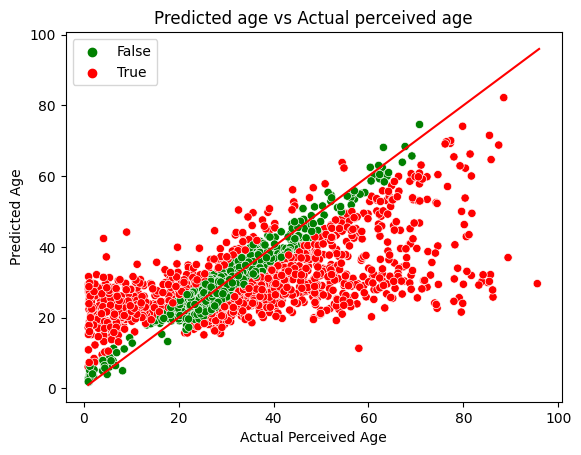

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
mae = np.mean(np.abs(np.ravel(predictions) - test_ages))
print(mae)
sns.scatterplot(x=test_ages, y=np.ravel(predictions), hue=np.abs(np.ravel(predictions) - test_ages) > 5, palette=['green', 'red'], sizes=20)

sns.lineplot(x=np.arange(min(test_ages), max(test_ages)+1), y=np.arange(min(test_ages), max(test_ages)+1), color='red')
plt.xlabel("Actual Perceived Age")
plt.ylabel("Predicted Age")
plt.title('Predicted age vs Actual perceived age')
#plt.savefig("D:/models/FINAL/CNN/CNN_dist_scatter.png", bbox_inches='tight')
plt.show()
#model.save("D:/models/FINAL/Mobile/testing/Mob_fine_aggregate.h5")